## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from IPython import display
import PIL
import glob
import imageio
import numpy as np
import cv2

## 导入数据

In [2]:
data_path = 'F:/ipython_notebook/tensorflow_gan_gcgan_faces_pro/data/faces'

def get_image_paths(directory):
    return [x.path for x in os.scandir(directory) if x.name.endswith(".jpg") or x.name.endswith(".png")]

images_path = get_image_paths(data_path)

In [3]:
def load_images(image_paths):
    iter_all_images = (cv2.imread(fn) for fn in image_paths)
    for i, image in enumerate(iter_all_images):
        if i == 0:
            all_images = np.empty((len(image_paths),) + image.shape, dtype=image.dtype)
        all_images[i] = image
    return all_images

images_data = load_images(images_path[:2000])

## tf封装数据

In [4]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

train_images = images_data.reshape(images_data.shape[0], 96, 96, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 生成器

In [5]:
def make_generator_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(24 * 24 * 768, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((24, 24, 768)))
    model.add(keras.layers.Conv2DTranspose(384, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(192, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model

In [6]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 442368)            44236800  
_________________________________________________________________
batch_normalization (BatchNo (None, 442368)            1769472   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 442368)            0         
_________________________________________________________________
reshape (Reshape)            (None, 24, 24, 768)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 384)       7372800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 384)       1536      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 384)       0

## 鉴别器

In [7]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[96, 96, 3]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='sigmoid'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
    return model

In [8]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 48, 48, 32)       

## 定义损失优化函数及callbacks

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

checkpoint_dir = 'F:/ipython_notebook/tensorflow_gan_gcgan_faces_pro/training_faces_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 定义超参

In [10]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

## 梯度下降

In [11]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
 
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
 
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## 训练过程

In [12]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5)/255.)
        plt.axis('off') 
    plt.savefig('./save_image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 4 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## 开始训练

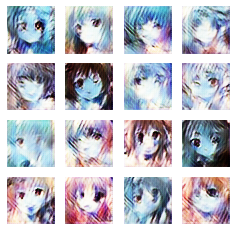

Wall time: 1h 34min 43s


In [13]:
%%time
train(train_dataset, EPOCHS)

## 查看训练最后一张图

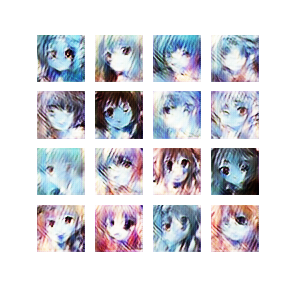

In [14]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
def display_image(epoch_no):
    return PIL.Image.open('./save_image/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## 所训练结果图片合并为gif动图

In [15]:
with imageio.get_writer('./save_image/dcgan.gif', mode='I') as writer:
  filenames = glob.glob('./save_image/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
os.rename('./save_image/dcgan.gif', './save_image/dcgan.gif.png')

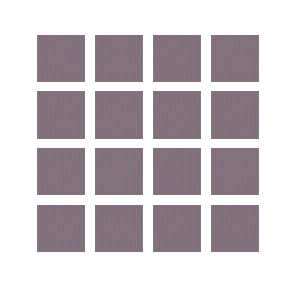

In [16]:
display.Image(filename="./save_image/dcgan.gif.png")